# Reverse Time Migration using a vector veflectivity based acoustic wave equation

This tutorial will guide the reader through an implementation of a Reverse Time Migration (RTM) algorithm using an acoustic wave equation based on the vector reflectivity.

This tutorial is based on the following paper:

<br>**Seismic modeling with vector reflectivity** (2020)
<br>N. D. Whitmore, J. Ramos-Martinez, Y. Yang, and A. A. Valenciano
<br>SEG Technical Program Expanded Abstracts 2020
<br>https://doi.org/10.1190/segam2020-3424516.1



In [1]:
from examples.seismic.source import RickerSource, TimeAxis, PointSource
from examples.seismic.preset_models import Gardners
from examples.seismic.utils import setup_geometry
from examples.seismic import Model, Receiver, plot_shotrecord, plot_velocity
from examples.seismic.vector_reflectivity import VectorReflectivityAcousticWaveSolver
from examples.seismic.vector_reflectivity.model_creators import model_layer

from devito import *

import numpy as np

import matplotlib.pyplot as plt

import gc

mpi4py is not available. You must install it


In [2]:
configuration['log-level'] = 'WARNING'

## Foward modelling

The acoustic wave equation can be rearranged to the following equation:

$$
m \frac{\partial^2 u}{\partial t^2} - \frac{1}{v_p} \nabla \cdot (v_p \nabla u) + 2\nabla \cdot(u\mathbf{R}) - 2u \nabla \cdot \mathbf{R} = S
$$

where $S = S(\mathbf{x}, t)$ is the source term, $v_p$ is the P-wave velocity, $\mathbf{R} = \dfrac{1}{2}\dfrac{\nabla z}{z}$ is the vector reflectivity and $z = v_p\rho$ is the acoustic impedance.

In [3]:
def vector_reflectivity_gardners(vp):
    b = Gardners(vp)
    z = vp/b
    Dzz = np.hstack((np.diff(z, axis=1), np.zeros((1,vp.shape[0])).T))
    Dxz = np.vstack((np.diff(z, axis=0), np.zeros(vp.shape[1])))
    r = [0.5 * Dzz/z, 0.5 * Dxz/z]

    return r

In [4]:
NX = 200
NZ = 120

SHAPE = (NX, NZ)
SPACING = (10., 10.)
ORIGIN = (0., 0.)
NLAYERS = 3
NBL = 50
SPACE_ORDER = 8
TIME_ORDER = 2
DTYPE = np.float64

# Velocity profile
vp = np.empty(SHAPE, dtype=DTYPE)

vp_top = 1.5 # km/s
vp_bottom = 3.5 # km/s

vp[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, NLAYERS)
for i in range(1, NLAYERS):
    vp[..., i*int(SHAPE[-1] / NLAYERS):] = vp_i[i]  # Bottom velocity

b = Gardners(vp, False)
# b = np.ones_like(vp)
r = vector_reflectivity_gardners(vp)

In [5]:
# model = Model(vp=vp, b=b, origin=ORIGIN, space_order=SPACE_ORDER, shape=SHAPE, dtype=DTYPE, spacing=SPACING, nbl=NBL, bcs='damp', staggered=NODE)
# model = load_marmousi('/home/filipe/projects/models/marmousi-resample/marmousi-resample-738x240.bin')
model = model_layer([1.5, 2.5, 3.5, 4.0, 5.0],np.float32)


In [6]:
# function to plot P wave velocit, and the x and z components of R
def img_model(img1, img2, img3, model):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("$v_P$ (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    plt_options_model.update({'cmap': 'Greys'})

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title(r"$\mathbf{R}$ (Horizontal component)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$\mathbf{R}$ (Vertical component)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

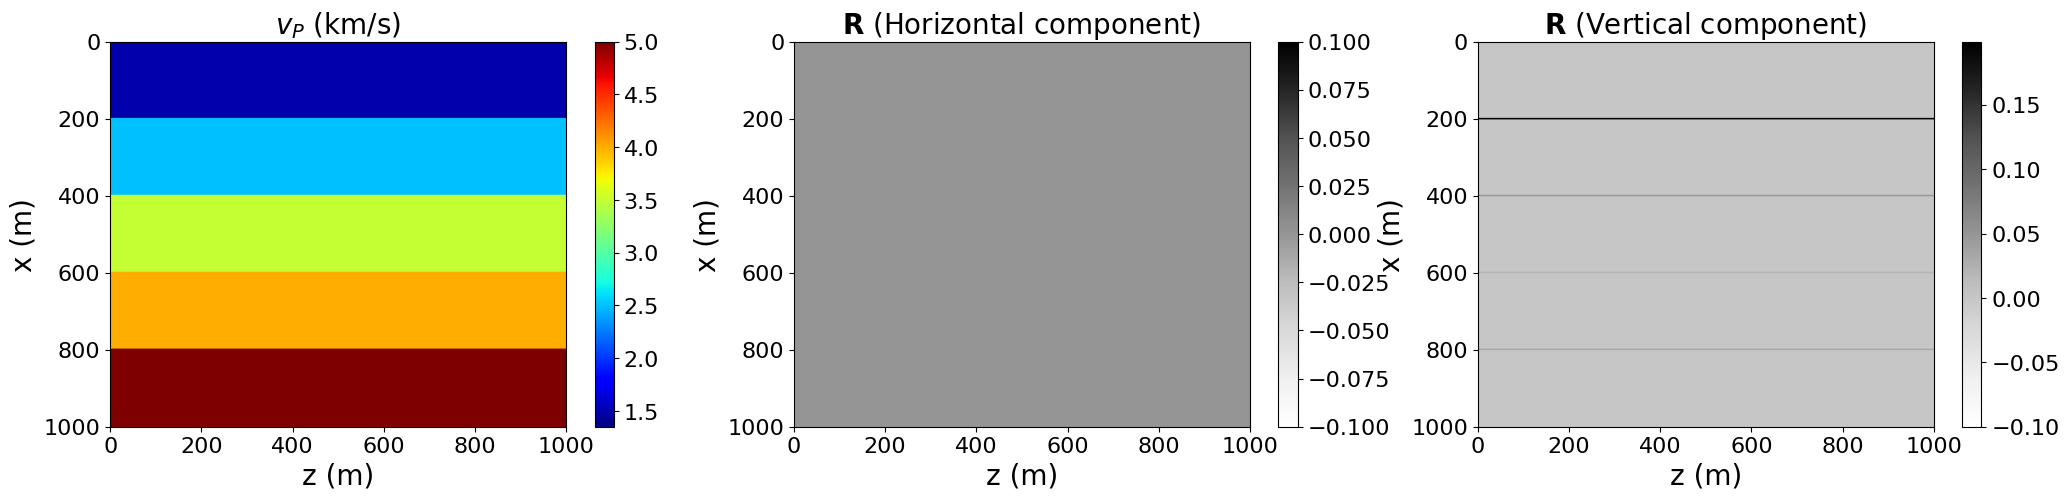

In [7]:
img_model(
    model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model.r[0].data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model.r[1].data[model.nbl:-model.nbl, model.nbl:-model.nbl], 
    model
)

In [8]:
f0 = 0.030  # peak/dominant frequency

s = model.grid.stepping_dim.spacing
damp = model.damp

# Time step in ms and time range:
# t0, tn = 0., 1800.
t0, tn = 0., 1300.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

geometry = setup_geometry(model, tn, f0=f0)
geometry = geometry.resample(dt)

In [9]:
# Function to create sources and receivers
def src_rec(model, geometry, src_pos, rec_depth, nrec):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis, npoint=1)

    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return src, rec

## The forward operator

The forward operator extrapolates the modelling equation by finite differences. The finite difference scheme implementation is done by Devito.

In [10]:
# def forward(model, geometry, src, rec):
#     u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
#                             space_order=model.space_order, staggered=NODE, save=geometry.nt)

#     m = model.m
#     r = model.r
#     vp = model.vp
#     dt = model.grid.stepping_dim.spacing

#     pde = m * u.dt2 - u.laplace + (- 1/vp*grad(vp) + 2*r).T * grad(u) + model.damp * u.dt
    

#     stencil = [Eq(u.forward, solve(pde, u.forward))]

#     src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
#     rec_term = rec.interpolate(expr=u)

#     op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
#     op(dt=geometry.dt)
    
#     return u

def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=model.space_order, staggered=NODE, save=geometry.nt)

    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*u.dt2 - rho * div(b * grad(u, .5), -.5) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u




In [11]:
# generating a shot with the source in the center of the model

# src_pos = np.array([model.domain_size[0] * .5, 10.], dtype=DTYPE)
src_pos = np.array([model.domain_size[0]/2, 10.], dtype=model.dtype)

rec_depth = 10.
nrec = model.shape[0]

src, rec = src_rec(model, geometry, src_pos, rec_depth, nrec)

u = forward(model, geometry, src, rec)

## Plotting shot data

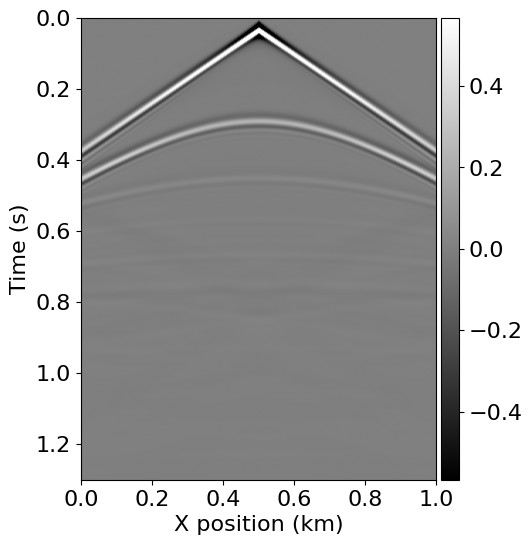

In [12]:
plot_shotrecord(rec.data, model, geometry.t0, geometry.tn)

## Plotting wavefields snapshots

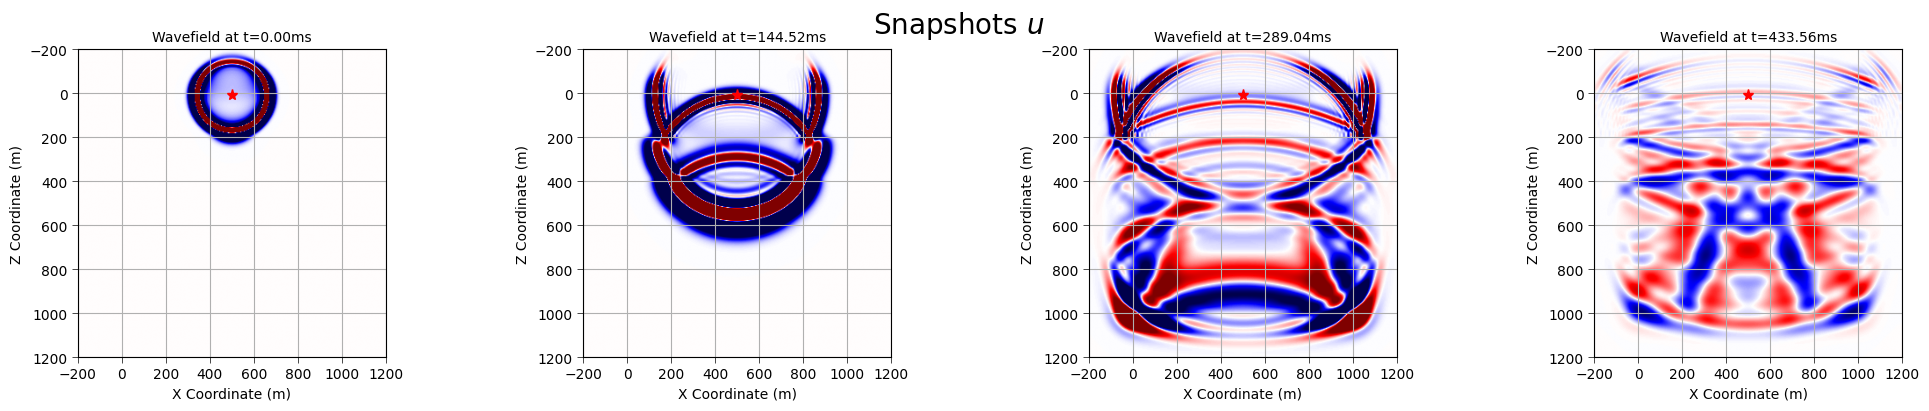

In [13]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
shape_pad = np.array(model.shape) + 2 * model.nbl
origin_pad = tuple([o - s*model.nbl for o, s in zip(model.origin, model.spacing)])
extent_pad = tuple([s*(n-1) for s, n in zip(model.spacing, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot_wavefield(a, src_pos, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 9
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=20)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(src_pos[0], src_pos[1], 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)


plot_wavefield(u, src_pos, title="Snapshots $u$")

## The adjoint operator

The adjoint operator solves the adjoint of the wave equation used in the modelling step with the receiver signal acting as the source term. The wave field is computed backwards in time, starting from the its state in final time $t = t_n$ and calculating the field in each timestep until the initial time $t = 0$. The adjoint wave equation in terms of the vector reflectivity is

$$
m\frac{\partial^2 v}{\partial dt} - \nabla \cdot \left[ v_p \nabla\left( \frac{1}{v_p} v \right) \right] + 2 \mathbf{R} \cdot \nabla v - 2v \nabla \cdot \mathbf{R} = R
$$

where $v$ is the adjoint pressure field (the wave field) and $R$ is the adjoint source, which stores the receiver signal.

In [14]:
# Function to create adjoint sources and receivers
def adjoint_src(model, geometry, src_pos):
    srca = PointSource(name='srca', grid=model.grid,
                       time_range=geometry.time_axis,
                       npoint=1)

    srca.coordinates.data[:, 0] = src_pos[0]
    srca.coordinates.data[:, 1] = src_pos[1]

    return srca

In [15]:
# def adjoint(model: Model, geometry, rec, srca=None):
#     v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
#                     space_order=model.space_order, staggered=NODE, save=geometry.nt)
#     m = model.m
#     vp = model.vp
#     r = model.r
#     dt = model.grid.stepping_dim.spacing

#     pde = m * v.dt2 - v.laplace - div((-grad(vp)/vp + 2*r) * v, .5) + model.damp * v.dt.T
    
#     stencil = [Eq(v.backward, solve(pde, v.backward))]

#     rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

#     terms = stencil
#     terms += rec_term

#     if srca:
#         srca_term = srca.interpolate(expr=v)
#         terms += srca_term

#     op = Operator(terms, subs=model.spacing_map)
#     op(dt=geometry.dt)
#     return v


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=model.space_order, staggered=NODE, save=geometry.nt)
    
    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*v.dt2 - div(b * grad(rho * v, .5), -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

## Imaging condition

We will use Claerbout's imaging condition where the image is constructed by cross-correlating the forward $u$ and adjoint $v$ wavefields in time:

$$
I = \int_0^{t_n} u(t)v(t) dt
$$

In order to compensate the lower energy carried by incident waves to reflectors at lower depths, we will also divide the final image componentwise by the source illumination:

$$
I = \frac{\int_0^{t_n} u(x, z, t)v(x, z, t) dt}{\int_0^{t_n} u(x, z, t)^2 dt}
$$

In [16]:
def imaging_condition(u: np.ndarray, v: np.ndarray, cumulative = False) -> np.array:
    """
    Implements the Claerbout's imaging condition.

    Parameters
    ----------
    u : np.ndarray
        The forward wavefield.
    v : np.ndarray
        The adjoint wavefield.
    cumulative : bool
        If `False`, only the final image will be returned. If `True`, returns the cumulative sum of the imaging condition along each time step.
    """
    H = np.sum(u**2, axis=0)

    if cumulative:
        return np.cumsum(u * v, axis=0) / (H + 1e-9)
    else:
        return np.sum(u * v, axis=0) / (H + 1e-9)

## Reverse-Time Migration

In a RTM procedure, one computes the imaging condition presented in the previous section for multiples shots whose sources are at different positions. The resulting images ($I_s$) are then stacked in order to produce the final image $I$:

$$
\begin{aligned}
I &= \sum_{s = 1}^{n_\mathrm{shots}} I_s\\
  &= \sum_{s = 1}^{n_\mathrm{shots}} \frac{\int_0^{t_n} u_s(x, z, t)v_s(x, z, t) dt}{\int_0^{t_n} u_s(x, z, t)^2 dt}
\end{aligned}
$$

where $u_s$ is the wavefield generated by the $s$-th shot, $v_s$ is its adjoint field and $n_\mathrm{shots}$ are the number of shots or sources.

In [17]:
def img_final(model, geometry, src_depth=10., nshots=10, shot_offset=0., rec_depth=10., cumulative = False):
    source_locations = np.empty((nshots, 2), dtype=np.float32)
    source_locations[:, 0] = np.linspace(0., model.shape[0]*model.spacing[0],
                                        num=nshots) + shot_offset
    source_locations[:, 1] = src_depth

    if cumulative:
        imf = TimeFunction(name="imf", grid=model.grid, space_order=model.space_order, time_order=TIME_ORDER, save=geometry.nt)
    else:
        imf = Function(name="imf", grid=model.grid, space_order=model.space_order)

    for i in range(nshots):
        print('Imaging source %d out of %d' % (i+1, nshots))
        src_pos = source_locations[i, :]
        
        src, rec = src_rec(model, geometry, src_pos, rec_depth, model.shape[0])
        
        u = forward(model, geometry, src, rec)
        v = adjoint(model, geometry, rec)
        imf.data[:] += imaging_condition(u.data, v.data, cumulative)
        del u
        del v
        gc.collect()

    return imf

In [18]:
imf_adj = img_final(model, geometry)

Imaging source 1 out of 10
Imaging source 2 out of 10
Imaging source 3 out of 10
Imaging source 4 out of 10
Imaging source 5 out of 10
Imaging source 6 out of 10
Imaging source 7 out of 10
Imaging source 8 out of 10
Imaging source 9 out of 10
Imaging source 10 out of 10


# Plotting the final image

In [19]:
def img(img, model, title=""):
    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

    plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0]
                                                     + model.domain_size[0],
                                                     model.origin[1] +
                                                     model.domain_size[1],
                                                     model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    scale = np.max(img.data[slices])

    img1 = ax.imshow(np.transpose(img.data[slices]), vmin=scale, vmax=-scale,
                        **plt_options_model)
    fig.colorbar(img1, ax=ax)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('z (m)', fontsize=20)
    ax.set_ylabel('x (m)', fontsize=20)
    ax.set_aspect('auto')

In [31]:
def img_diff(i1, i2, model, title=""):
    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

    plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0]
                                                     + model.domain_size[0],
                                                     model.origin[1] +
                                                     model.domain_size[1],
                                                     model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    scale = np.max(i1 - i2)

    img1 = ax.imshow(np.transpose(i1 - i2), vmin=scale, vmax=-scale,
                        **plt_options_model)
    fig.colorbar(img1, ax=ax)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('z (m)', fontsize=20)
    ax.set_ylabel('x (m)', fontsize=20)
    ax.set_aspect('auto')

In [20]:
def lapla(model, image):
    lapla = Function(name='lapla', grid=model.grid, space_order=model.space_order)
    stencil = Eq(lapla, -image.laplace)
    op = Operator([stencil])
    op.apply()
    return lapla

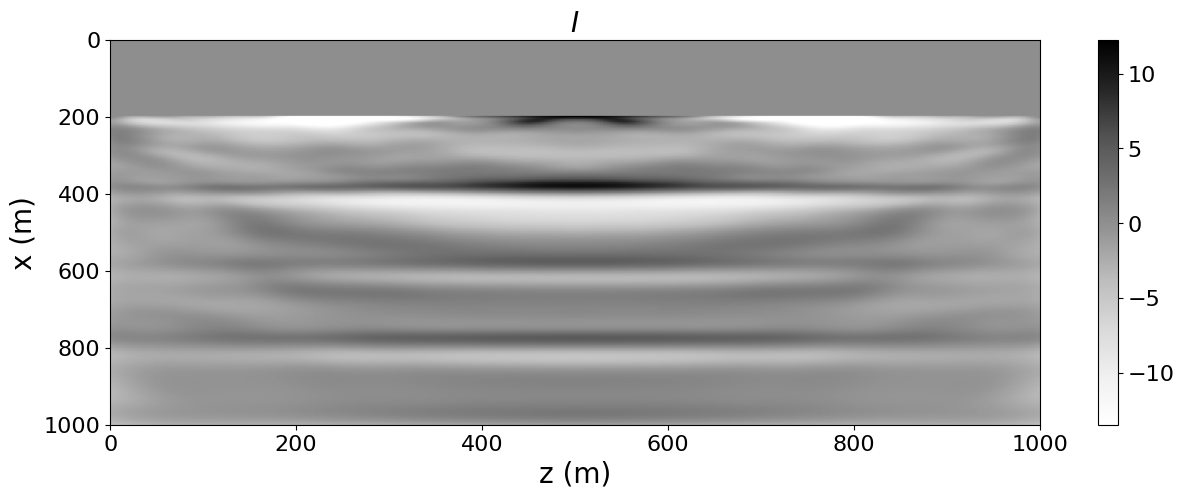

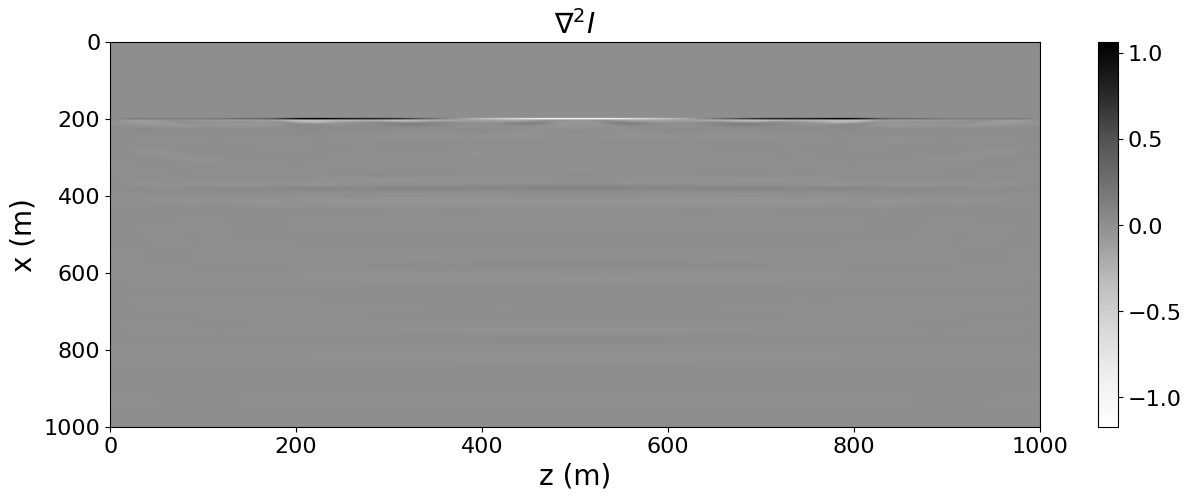

In [21]:
# Applying laplacian filter
image_final_adj = lapla(model, imf_adj)

# Zeroing the water layer

watermask = 1 - ((model.vp.data <= 1.5).astype(np.float32))
# imf_adj.data[:, :90] = 0.
# image_final_adj.data[:, :90] = 0.
imf_adj.data[:] *= watermask
image_final_adj.data[:] *= watermask

img(imf_adj, model, title="$I$")
img(image_final_adj, model, title="$\\nabla^2 I$")

In [22]:
imf_adj.data[model.nbl:-model.nbl, model.nbl:-model.nbl].tofile(f'image_nx{model.shape[0]}_nz{model.shape[1]}.bin')
image_final_adj.data[model.nbl:-model.nbl, model.nbl:-model.nbl].tofile(f'lap_nx{model.shape[0]}_nz{model.shape[1]}.bin')

In [62]:
imf_vr_adj = np.fromfile('ps/vr_image_nx251_nz251.bin', np.float32).reshape(251, 251)
imf_cla_adj = np.fromfile('image_nx251_nz251.bin', np.float32).reshape(251, 251)

np.float32(0.00069379807)

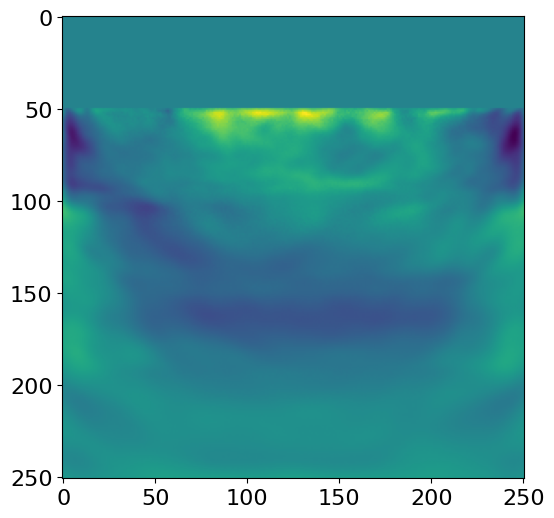

In [63]:
plt.imshow((imf_cla_adj - imf_vr_adj).T)
np.max(np.abs(imf_cla_adj - imf_vr_adj))

In [80]:
def plot_trace_z(traces, labels, model, title='', start_idx = 0):
    # t_axis = geometry.time_axis.time_values
    plt.figure(figsize=(10, 9))
    z_axis = np.linspace(0, model.domain_size[1], num=model.shape[1])

    for i, tr in enumerate(traces):
        plt.plot(tr[start_idx:], z_axis[start_idx:], label=labels[i])

    plt.legend(fontsize='small')
    plt.title(title)
    plt.xlabel('Amplitude')
    plt.ylabel('Depth (m)')

    plt.grid()
    plt.gca().invert_yaxis()
    # plt.figsize((10, 10))

    plt.show()

In [64]:
n = np.size(imf_vr_adj - imf_cla_adj)
RMS = (np.sum((imf_vr_adj - imf_cla_adj)**2)/n)**.5
RMS

np.float32(0.00012087818)

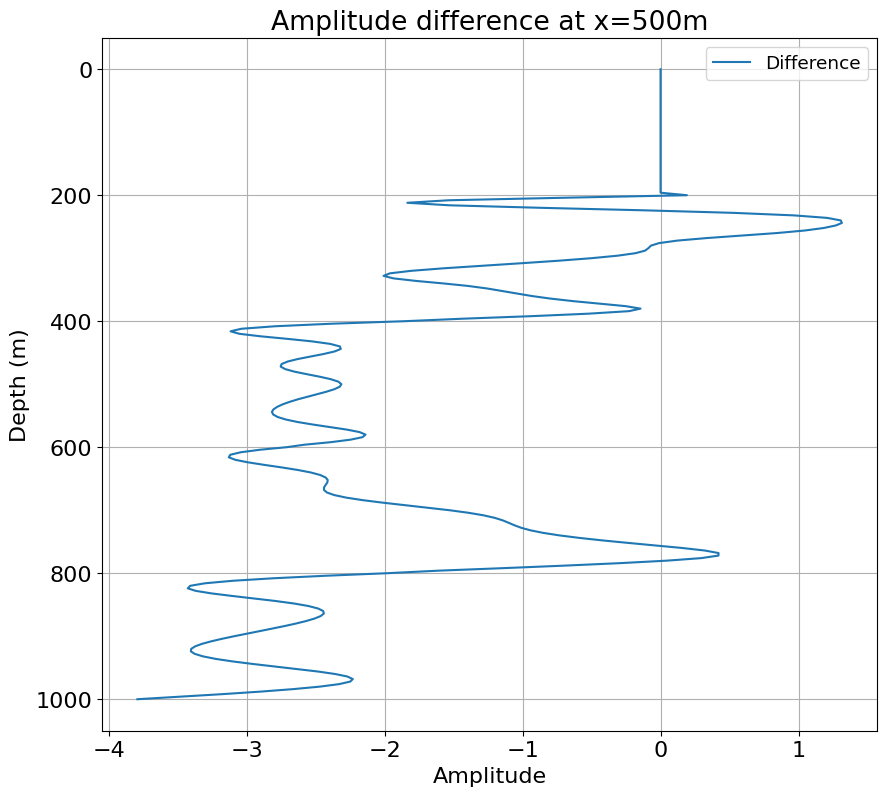

In [ ]:
traces = [(imf_vr_adj).T[:, 250]]
plot_trace_z(traces, ['Difference'], model, title='Amplitude difference at x=500m')

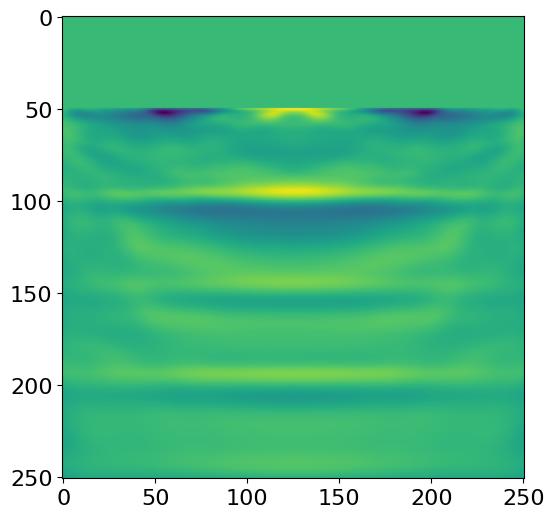

In [61]:
plt.imshow(imf_vr_adj.T)

# Imaging condition through time

In [23]:
# Save each step of the sum along the time axis
# imf_cum_adj = img_final(model, geometry, cumulative=True)

In [24]:
# Erasing the water layer
# imf_cum_adj.data[:, :, :90] = 0.

In [25]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
shape_pad = np.array(model.shape) + 2 * model.nbl
origin_pad = tuple([o - s*model.nbl for o, s in zip(model.origin, model.spacing)])
extent_pad = tuple([s*(n-1) for s, n in zip(model.spacing, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot_imaging_condition(a, nsnaps = 4, title=None, outfile=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(a.data[kt, :, :])
    amin = 10 * np.max(a.data[kt, :, :])

    slc = slice(model.nbl, -model.nbl)
    
    nrows = int(np.ceil(nsnaps / 2))

    factor = int(np.ceil(time_range.num / nsnaps)) - 1

    fig, axes = plt.subplots(nrows, 2, sharex=True, figsize=(16,8*nrows))
    fig.suptitle(title, size=20)

    for count, ax in enumerate(axes.ravel()):
        # snapshot = factor * (count + 1)
        if count >= nsnaps:
            break
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, slc, slc]), cmap="Greys", extent=plt_extent)
        # ax.plot(model.domain_size[0] * .5, 10, 'red', linestyle='None', marker='*',
        #         markersize=8, label="Source")
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("t=%.2fms" % (factor*(count+1)*dt), fontsize=10)
        ax.set_xlabel("x (m)", fontsize=10)
        ax.set_ylabel("z (m)", fontsize=10)
    
    fig.tight_layout()

    if outfile:
        fig.savefig(outfile)


# plot_imaging_condition(imf_cum_adj, 8, outfile='imaging-condition.png')

## Adjoint test

A way to test the forward and the adjoint operators is by applying the definition of an adjoint transform: let $A$ an transform from a inner-product space $\mathcal{G}$ to a inner-product space $\mathcal{H}$. The adjoint $A^T$ of $A$ is the transform satisfying

$$
\langle Ax, y \rangle = \langle x, A^Ty \rangle
$$

for every $x$ in $\mathcal{G}$ and $y$ in $\mathcal{H}$. In our case, $\mathcal{G}$ is the space of sources signals, and $\mathcal{H}$ is the space of receivers signals.

<!-- the domain of the `adjoint` operator will be the space of receivers - acting as sources -, and its image will be the space of adjoint sources - which will act as receivers at the original sources positions. -->


In [26]:
src_pos = np.array([0.5 * model.domain_size[0], 10.], dtype = model.dtype)
rec_depth = 0.5*model.domain_size[1]
# rec_depth = 30.
nrec = 1
src, rec = src_rec(model, geometry, src_pos, rec_depth, nrec)

u = forward(model, geometry, src, rec)

In [27]:
srca = adjoint_src(model, geometry, src_pos)

v = adjoint(model, geometry, rec, srca)

In [28]:
if model.dtype == np.float64:
    eps = 1e-11
elif model.dtype == np.float32:
    eps = 1e-6

In [29]:
term1 = norm(rec) ** 2 # <Ax, y>
term2 = srca.data.T @ src.data # <x, A^Ty>

print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))

assert np.isclose((term1 - term2)/term1, 0., atol=eps)

/tmp/ipykernel_375895/3984813024.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'


<x, A*y>: 3.515300, <Ax,y>: 3.515304, difference: -1.3565e-06, ratio: 0.999999


AssertionError: 